In [8]:
import tensorflow as tf
import pathlib
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import scipy

AUTOTUNE = tf.data.AUTOTUNE # prompts the tf.data runtime to tune the value dynamically at runtime



In [9]:
batch_size = 32
img_height = 28
img_width = 28

def create_dataset_from_path(path):

    # function that converts a file path to an (img, label) pair
    def get_label(file_path):
      # Convert the path to a list of path components
      parts = tf.strings.split(file_path, os.path.sep)
      # The second to last is the class-directory
      one_hot = parts[-2] == class_names
      # Integer encode the label
      return tf.argmax(one_hot)

    def decode_img(img):
      # Convert the compressed string to a 3D uint8 tensor
      img = tf.io.decode_jpeg(img, channels=1)
      # Resize the image to the desired size
      return tf.image.resize(img, [img_height, img_width])

    def process_path(file_path):
      label = get_label(file_path)
      # Load the raw data from the file as a string
      img = tf.io.read_file(file_path)
      img = decode_img(img)
      return img, label

    # Make the imgs in to batches
    def configure_for_performance(ds):
      ds = ds.cache()
      ds = ds.shuffle(buffer_size=1000)
      ds = ds.batch(batch_size)
      ds = ds.prefetch(buffer_size=AUTOTUNE)
      return ds

    data_dir = pathlib.Path(path) # for pycharm
    #data_dir = pathlib.Path('mnist_png/training') # for the jupyter notebook

    print(path+'\\*\\*')

    # Shuffle might be better set to False but this seems better for now
    list_ds = tf.data.Dataset.list_files((path+'\\*\\*'), shuffle=True)
    image_count = len(list_ds)
    class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
    print(class_names)
    val_size = int(image_count * 0.2)
    train_ds = list_ds.skip(val_size) # skips x initial elements from this dataset.
    val_ds = list_ds.take(val_size)
    print(tf.data.experimental.cardinality(train_ds).numpy())
    print(tf.data.experimental.cardinality(val_ds).numpy())


    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

    normalization_layer = tf.keras.layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    # normalized_ds  -> range goes from 0 to 1
    # train_ds  -> range goes from 0 to 255

    normalized_ds = configure_for_performance(normalized_ds)
    val_ds = configure_for_performance(val_ds)

    print(normalized_ds)
    return normalized_ds, val_ds

In [27]:
#normalized_ds, val_ds = create_dataset_from_path('Classifier\\mnist_png\\training')
normalized_ds, val_ds = create_dataset_from_path('mnist_png\\me')


mnist_png\me\*\*
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
200
50
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [5]:
# Using the normalized
for imageBatch, labelBatch in normalized_ds.take(1):
    print("Image shape: ", imageBatch.numpy()[0].shape)
    print("Label: ", labelBatch.numpy()[0])
    print("Label: ", labelBatch.numpy())
    #print(np.min(image), np.max(image))

    # f = open("demofile.txt", "a")
    # for a in range(28): # goes from 0 to 27
    #   for b in range(28):
    #     print(f'{round(float(image[b][a][0]), 1)}',end='')
    #     f.write(str(round(float(image[b][a][0]), 1)))
    #   print(f'\n')
    #   f.write('\n')
    # f.close()

    imgToBeDisplayed = imageBatch.numpy()[0]

    extraChannel = np.zeros((28,28,1))
    imgToBeDisplayed = np.concatenate((imgToBeDisplayed,extraChannel), axis=2)
    imgToBeDisplayed = np.concatenate((imgToBeDisplayed,extraChannel), axis=2)
    imgToBeDisplayed = imgToBeDisplayed * 255

    print("Image shape: ", imgToBeDisplayed.shape)
    print("Label: ", labelBatch.numpy()[0])
    # #print(f'->{image}')

    print(np.min(imageBatch[0]), np.max(imageBatch[0]))

    image_uint8 = imgToBeDisplayed.astype(np.uint8)
    img = Image.fromarray(image_uint8, 'RGB')
    #img.show()
    img.save('Classifier\\temp.png')

PIL.Image.open('Classifier\\temp.png')


Image shape:  (28, 28, 1)
Label:  0
Label:  [0 4 0 5 5 6 2 4 2 5 8 4 0 5 0 9 3 0 6 8 5 8 3 1 8 5 0 3 9 4 1 3]
Image shape:  (28, 28, 3)
Label:  0
0.0 0.9960785


FileNotFoundError: [Errno 2] No such file or directory: 'Classifier\\temp.png'

In [ ]:
os.remove('Classifier/temp.png')


In [11]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=15, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28, 28, 1),
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters=20, kernel_size=(10,10), padding='Same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters=25, kernel_size=(15,15), padding='Same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [28]:
epochs=10

history = model.fit(
  normalized_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/10
7/7 [==============================] - 1s 72ms/step - loss: 0.0234 - accuracy: 0.9900 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
7/7 [==============================] - 0s 24ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.5359 - val_accuracy: 0.9800
Epoch 3/10
7/7 [==============================] - 0s 25ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 0s 22ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 24ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 27ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 21ms/step - loss: 9.1726e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

In [10]:
model.save('Classifier/saved_models')

model.summary()

INFO:tensorflow:Assets written to: Classifier/saved_models\assets


INFO:tensorflow:Assets written to: Classifier/saved_models\assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 15)        390       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 15)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 20)        30020     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 20)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 25)          112525    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 25)         0

In [3]:
model = tf.keras.models.load_model('saved_models')

In [3]:
model = tf.keras.models.load_model('Classifier/saved_models')

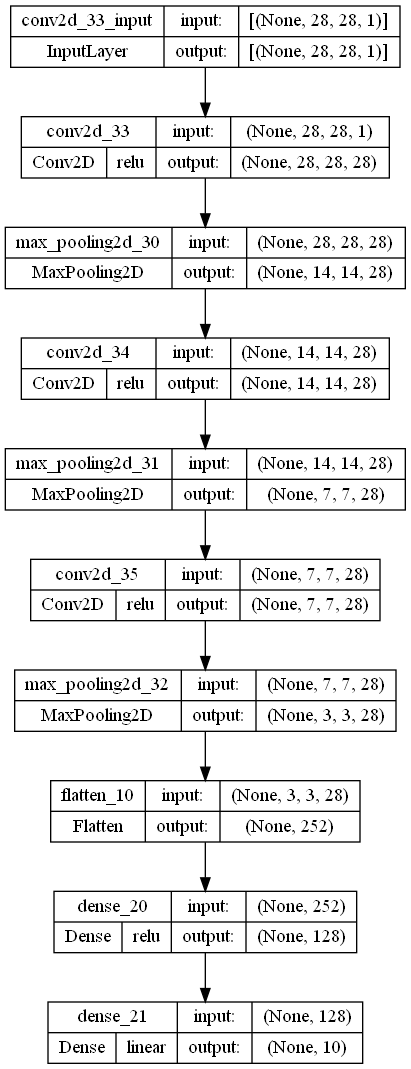

In [7]:

tf.keras.utils.plot_model(model, to_file='model.png',
                          show_shapes=True, show_layer_activations=True)

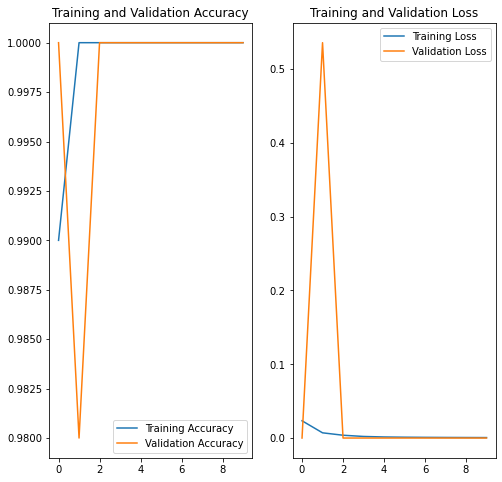

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
# Read the image
# img = Image.open('Classifier/mnist_png/testing/0/3.png')
#
# # define a transform to convert the image to grayscale
# transform = transforms.Grayscale()
#
# # apply the above transform on the image
# img = transform(img)
#
# # dispaly the image
# #img.show()
#
# convert_tensor = transforms.ToTensor()
#
# img_tensor = convert_tensor(img)
#
# print(img_tensor.shape)

testing_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path('Classifier/mnist_png/me'),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1,
  color_mode='grayscale'
  )

testing_normalized_ds = testing_ds.map(lambda x, y: (normalization_layer(x), y))
testing_image_batch, testing_labels_batch = next(iter(testing_normalized_ds))


In [113]:
#print(train_ds[0])
model.predict(testing_ds)

2/2 [==============================] - 0s 5ms/step


array([[ -292.7022  , -1864.0464  ,  1193.3007  ,  1272.931   ,
        -1080.4885  ,   -43.669655,  -760.62317 , -1429.5154  ,
          257.2695  , -2579.77    ],
       [  259.88556 , -1370.9014  ,   270.61807 ,    90.21795 ,
         -976.1065  ,  -378.90308 ,  -185.88264 , -1444.0776  ,
          745.89233 ,  -855.32806 ]], dtype=float32)